In [41]:
# from __future__ import unicode_literals
import numpy as np
import glob
from nltk.tokenize import sent_tokenize, word_tokenize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
path = '/Users/shikha/Documents/projects/omdena/dataset/example/*'
files = glob.glob(path)
data = {}
# label 0 means no ptsd
data[0] = []
# label 1 means ptsd
data[1] = []
count = 0
separator = ""
for name in files: # 'file' is a builtin type, 'name' is a less-ambiguous variable name.
    try:
        with open(name) as f:
            content = f.readlines()
            print len(content)
            # limiting the conversation for now
            content = separator.join(content[:100])
            count += 1
            if count % 2 == 0:
                data[0].append(content)
            else:
                data[1].append(content)
    except IOError as exc:
        print "IO Error"

print "Total Clients processed: ", count

2745
3293
2787
Total Clients processed:  3


In [43]:
def load_glove_model(gloveFile):
    print "\nLoading Glove Model..."
    f = open(gloveFile,'r')
    wordList = []
    wordVectors = []
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        wordList.append(word)
        wordVectors.append(embedding)
    wordVectors = np.array(wordVectors)
    print "Done. ",len(wordList)," words loaded!"
    print wordVectors[wordList.index('woman')]

    return wordList, wordVectors

def load_dataset(filename=""):
    X = []
    Y = []
    for label, transcripts in data.items():
        X += [val for val in transcripts]
        Y += [label] * len(transcripts)
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [44]:
root = "/Users/shikha/Documents/projects/omdena/"
glove_file = root + "glove/glove.6B.100d.txt"

# Load glove file
wordsList, wordVectors = load_glove_model(glove_file)


Loading Glove Model...
Done.  400000  words loaded!
[ 0.59368   0.44825   0.5932    0.074134  0.11141   1.2793    0.16656
  0.2407    0.39045   0.32766  -0.75034   0.35007   0.76057   0.38067
  0.17517   0.031791  0.46849  -0.21653  -0.46282   0.39967   0.16623
 -0.011477  0.044059  0.30325   0.6153    0.47047  -0.44036  -1.5963
  0.18433   0.23193   0.20452   0.51617   0.65734  -0.3452    0.23446
 -0.62004  -0.68741   0.28575   1.0605    0.46916  -0.85149   0.10154
  0.21426  -0.20587   0.23636   0.21321  -0.21287   0.12107   0.18766
 -0.23282  -0.25499  -0.39631   0.84379   1.6801   -0.40941  -1.9976
 -0.69868   0.21732   1.2197    0.55126   0.44095   0.72588  -0.092053
 -0.022406  0.72039   0.1076    0.84116   0.30312  -0.42544   0.056362
  0.13109  -0.071181 -0.10579   0.56677   0.54547   0.84113   0.14861
 -0.62628  -0.68391  -1.0831   -0.088385  0.32167   0.47794   0.091868
 -1.2559   -1.2268    0.085401  0.36833   0.081566 -0.76611   0.87751
 -0.22008   0.82401  -0.092207 -0.45

In [45]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 100)


In [46]:
# filename = dataset + "/train/abc"
X, Y = load_dataset()

In [47]:
def tokenize(doc, decode=True):
    if decode:
        return word_tokenize(doc.decode('utf-8'))
    else:
        return word_tokenize(doc)

In [48]:
# counting average no words in a sentence
count = 0
for transcript in X:
    words = tokenize(transcript)
    count += len(words)
avg = count/X.shape[0]
print "Average no of words in a sentence = ", avg

Average no of words in a sentence =  3210


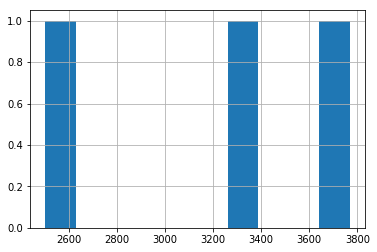

count       3.000000
mean     3210.333333
std       646.973209
min      2501.000000
25%      2931.500000
50%      3362.000000
75%      3565.000000
max      3768.000000
dtype: float64

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

transcripts_len = [len(tokenize(transcript)) for transcript in X]
pd.Series(transcripts_len).hist()
plt.show()
pd.Series(transcripts_len).describe()

In [50]:
# usually based on average no of words in the sentence
maxSeqLength = 25
batch_size = 1

In [51]:
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8

In [52]:
# Run only once and save data in npy file
# converting words to ids from glove

# ids = np.zeros((X.shape[0], maxSeqLength), dtype='int32')
# i = 0
# for transcript in X:
#     words = tokenize(transcript)
#     indexCounter = 0
#     for word in words:
#         try:
#             ids[i][indexCounter] = wordsList.index(word)
#         except ValueError:
#             ids[i][indexCounter] = 399999 #Vector for unknown words
#         indexCounter = indexCounter + 1
#         if indexCounter >= maxSeqLength:
#            break
#     i += 1

# np.save('trascript_ids', ids)

In [53]:
X = np.load('trascript_ids.npy')

# train_len = int(0.8 * X.shape[0])
# X_train = X[0:train_len]
# Y_train = Y[0:train_len]
# X_test = X[train_len:]
# Y_test = Y[train_len:]
train_len = X.shape[0]
X_train = X
Y_train = Y
X_test = X
Y_test = Y

In [54]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
# valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))
# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [55]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

('Sample input size: ', torch.Size([1, 25]))
('Sample input: \n', tensor([[399999, 399999, 399999, 399999,     45, 399999, 399999,     45, 399999,
             45,     23, 399999,   9085,     24, 399999,      1,    886,      9,
            253,      2, 399999,    269,     61,     53,    809]],
       dtype=torch.int32))
()
('Sample label size: ', torch.Size([1]))
('Sample label: \n', tensor([0]))


In [93]:
from torch import nn
import torch.nn.functional as F

class diagnosis_LSTM(nn.Module):
    def __init__(self, embedding_dim, num_layers, num_outputs, vocab_len, hidden_size):
        super(diagnosis_LSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.embeddings = nn.Embedding(vocab_len, embedding_dim)
        print 'Embedding layer is ', self.embeddings
        print 'Embedding layer weights ', self.embeddings.weight.shape
        
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_outputs)
#         self.output = nn.LogSoftmax(dim=1)
        self.output = nn.Sigmoid()
    
    def forward(self, input, batch_size):
        embeddings_out = self.embeddings(input)
        print 'Embedding layer output shape', embeddings_out.shape
#         print 'Embedding layer output ', embeddings_out
        
        # initializing the hidden state to 0
        hidden=None
        lstm_out, h = self.lstm(embeddings_out, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)
        lstm_out = torch.sum(lstm_out, dim=0)
        print 'LSTM layer output shape', lstm_out.shape
#         print 'LSTM layer output ', lstm_out
        
        fc_out = self.fc(lstm_out.contiguous().view(-1, self.hidden_size))
        print 'FC layer output shape', fc_out.shape
#         print 'FC layer output ', fc_out
        
#         log_probs = F.log_softmax(fc_out)
#         print "log probs shape", log_probs.shape
#         return log_probs
        sigm_out = self.output(fc_out)
        print 'Sigmoid layer output shape', sigm_out.shape
        print 'Sigmoid layer output ', sigm_out
        
        out = sigm_out.view(batch_size, -1)
        print 'Output layer output shape', out.shape
        print 'Output layer output ', out
        
        print 'Final ptsd prediction, ', out[:,-1]
        return out

In [94]:
# Instantiate the model w/ hyperparams
num_layers = 2
num_classes = 1
hidden_size = 256
embedding_dim = 100 # it should match with the glove file embeddings dimension above
vocab_len = len(wordsList)+1 # +1 for the 0 padding

net = diagnosis_LSTM(embedding_dim, num_layers, num_classes, vocab_len, hidden_size)
print net

Embedding layer is  Embedding(400001, 100)
Embedding layer weights  torch.Size([400001, 100])
diagnosis_LSTM(
  (embeddings): Embedding(400001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (output): Sigmoid()
)


In [97]:
# training loop
num_epochs = 3
learning_rate = 0.0001

loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss
optim = torch.optim.SGD(net.parameters(), lr = learning_rate)
for epoch in range(num_epochs):
    ep_loss = 0.
        
    # loop over training data
    sample_x = sample_x.type(torch.LongTensor)
    print "sample_x shape", sample_x.shape  # should be (batch_size, max_seq_length)
    for i in range(len(sample_x)):
        sent = torch.LongTensor(sample_x[i]).unsqueeze(0)
        target = sample_y[i].unsqueeze(0)
        
        pred = net.forward(sent, batch_size)
        loss = loss_fn(pred, target)
        loss.backward()
        optim.step()
        optim.zero_grad()
        ep_loss += loss
    
    print(epoch, ep_loss)

sample_x shape torch.Size([1, 25])
Embedding layer output shape torch.Size([1, 25, 100])
LSTM layer output shape torch.Size([256])
FC layer output shape torch.Size([1, 1])
Sigmoid layer output shape torch.Size([1, 1])
Sigmoid layer output  tensor([[0.4550]], grad_fn=<SigmoidBackward>)
Output layer output shape torch.Size([1, 1])
Output layer output  tensor([[0.4550]], grad_fn=<ViewBackward>)
Final sentiment prediction,  tensor([0.4550], grad_fn=<SelectBackward>)
(0, tensor(0., grad_fn=<AddBackward>))
sample_x shape torch.Size([1, 25])
Embedding layer output shape torch.Size([1, 25, 100])
LSTM layer output shape torch.Size([256])
FC layer output shape torch.Size([1, 1])
Sigmoid layer output shape torch.Size([1, 1])
Sigmoid layer output  tensor([[0.4550]], grad_fn=<SigmoidBackward>)
Output layer output shape torch.Size([1, 1])
Output layer output  tensor([[0.4550]], grad_fn=<ViewBackward>)
Final sentiment prediction,  tensor([0.4550], grad_fn=<SelectBackward>)
(1, tensor(0., grad_fn=<Add